import csv
import sys
import os
import gc
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from itertools import chain
from collections import Counter
from tqdm import tqdm,tqdm_notebook
from glob import glob
import time

import cv2
from matplotlib import pyplot as plt
from IPython.display import clear_output
import re

from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate, ReLU, LeakyReLU, GlobalAveragePooling2D, GlobalMaxPooling2D,Add
from keras.layers import UpSampling2D, Conv2DTranspose, Lambda,AveragePooling2D, Multiply
from keras.layers.merge import concatenate, add
from keras import metrics
from keras.optimizers import Adam

from keras import backend as K
import keras
import tensorflow as tf

from keras.backend import tf as ktf
K.set_floatx('float32')



from classification_models import Classifiers

FOLDS = 3

SHAPE = (256,256, 5)
BATCH_SIZE = 1

In [2]:
def get_model(backbone,ch):
    classifier, preprocess_input = Classifiers.get(backbone)
    base_model = classifier((None,None, ch), weights=None,include_top = False)

    block_1 = base_model.get_layer(index = 1065).output
    block_2 = base_model.get_layer(index = 577).output
    block_3 = base_model.get_layer(index = 251).output
    block_4 = base_model.get_layer(index = 4).output
    x = Dropout(0.3)(base_model.output)
    x = UpSampling2D((2,2))(x)
    x = concatenate([x,block_1])
    x = Dropout(0.2)(x)
    
    x = BatchNormalization()(x)
    x = Conv2D(16,(3,3),padding = 'same')(x)
    x = UpSampling2D((2,2))(x)
    
    x = concatenate([x,block_2])
    x = BatchNormalization()(x)
    x = Conv2D(16,(3,3),padding = 'same')(x)
    x = UpSampling2D((2,2))(x)
    
    x = concatenate([x,block_3])
    x = BatchNormalization()(x)
    x = Conv2D(16,(3,3),padding = 'same')(x)
    x = UpSampling2D((2,2))(x)
    
    x = concatenate([x,block_4])
    x = BatchNormalization()(x)
    x = Conv2D(16,(3,3),padding = 'same')(x)
    
    mask_conv = Conv2D(1,(3,3),padding = 'same', name = 'mask')(x)
    mask_conv = BatchNormalization(name = 'bn_mask')(mask_conv)
    mask_conv = Activation('sigmoid', name = 'act_mask')(mask_conv)
    target = GlobalMaxPooling2D(name = 'gmp_mask')(mask_conv)
    
    no_mask_conv = Conv2D(1,(3,3),padding = 'same', name = 'no_mask')(x)
    no_mask_conv = BatchNormalization(name = 'bn_no_mask')(no_mask_conv)
    no_mask_conv = Activation('sigmoid', name = 'act_no_mask')(no_mask_conv)
    no_target = GlobalMaxPooling2D(name = 'gmp_no_mask')(no_mask_conv)

    sum_targets = add([mask_conv, no_mask_conv])
    sum_targets = GlobalAveragePooling2D(name = 'gap_sum')(sum_targets)
    model = Model(inputs=[base_model.input], outputs=[target,no_target, sum_targets])
    
    return model

In [3]:
test_paths = glob('./test/*')
len(test_paths)

1000

In [5]:
channels = 3

model = get_model('seresnext50',channels)

c = keras.optimizers.Adam(lr = 0.001)
model.compile(c, 
                  loss= 'binary_crossentropy')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [38]:
folds_masks = []
for fold in range(FOLDS):
    masks = np.array([])
    print('FOLD {}'.format(fold))
    model.load_weights('weights/seresnext50_{}ch_{}-Best.hdf5'.format(channels,fold))
    batch = []
    first = False
    for path in test_paths[18:19]:
        
        #features map
        layer_name = 'act_mask'
        intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
        
        image = np.load(path)
        if channels==3:
                image = image[:,:,:3]
        else:
            image[:,:,3:] = np.round((image[:,:,3:]/28001)*255)
            
        image = image.astype(int)
        #mirror
        new_im = np.zeros((320,320,channels))
        new_im[32:-32,32:-32] = image
        new_im[:32] = np.flipud(new_im[32:64])
        new_im[-32:] = np.flipud(new_im[-64:-32])
        new_im[:,:32] = np.fliplr(new_im[:,32:64])
        new_im[:,-32:] = np.fliplr(new_im[:,-64:-32])
        
        
        batch.append(new_im/255)
        p = False
        if len(batch)==BATCH_SIZE:
            intermediate_output = intermediate_layer_model.predict(np.array(batch))
            mask = intermediate_output.reshape(len(batch),160,160)[:,16:-16,16:-16]
            batch = []
            if first ==False:
                masks = np.array(mask)
                first = True
            else:
                masks = masks = np.concatenate((masks,np.array(mask)))
            p = True
            
    if p==False:
        intermediate_output = intermediate_layer_model.predict(np.array(batch))
        mask = intermediate_output.reshape(len(batch),160,160)[:,16:-16,16:-16]
        batch = []
        if first ==False:
            first = True
            masks = np.array(mask)
        else:
            first = True
            masks = np.concatenate((masks,np.array(mask)))
        
    print(masks.shape)
    folds_masks.append(np.array(masks))
folds_masks = np.array(folds_masks)

FOLD 0
(1, 128, 128)
FOLD 1
(1, 128, 128)
FOLD 2
(1, 128, 128)


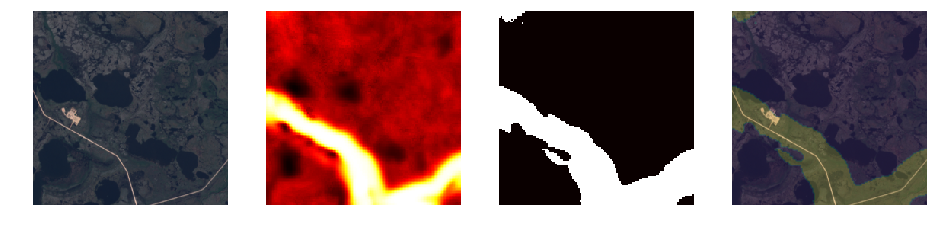

In [39]:
tr = 0.6
for n_m,path in enumerate(test_paths[18:19]):
    image = np.load(path)[:,:,:3]
    plt.figure(figsize = (16,20))
    plt.subplot(1,4,1).imshow(image)
    plt.subplot(1,4,1).axis('Off')
    m =np.array(masks[n_m])
    plt.subplot(1,4,2).imshow(m, cmap = 'hot')
    plt.subplot(1,4,2).axis('Off')
    #binary_mask
    b_m = np.array(m)
    b_m[np.where(b_m<tr)] = 0
    b_m[np.where(b_m>0)] = 1
    plt.subplot(1,4,3).imshow(b_m, cmap = 'hot')
    plt.subplot(1,4,3).axis('Off')
    
    plt.subplot(1,4,4).imshow(image)
    plt.subplot(1,4,4).imshow(cv2.resize(b_m,(256,256)), alpha = 0.2)
    plt.subplot(1,4,4).axis('Off')

    plt.show()

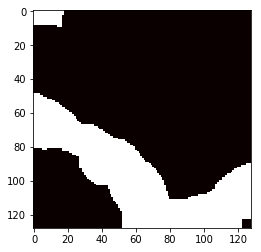

In [40]:
kernel = np.ones((11,11),np.uint8)
#b_m1 = cv2.erode(b_m,kernel,iterations = 1)
b_m_changed = cv2.dilate(b_m,kernel,iterations = 1)
kernel = np.ones((9,9),np.uint8)
b_m_ch = cv2.erode(b_m_changed,kernel,iterations = 1)
b_m1 = cv2.morphologyEx(b_m_ch, cv2.MORPH_CLOSE, kernel)
plt.imshow(b_m1.reshape(128, 128), cmap='hot')

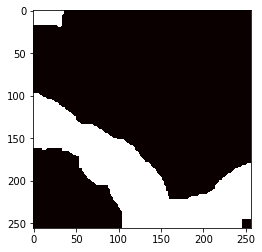

In [41]:
resized_b_m = cv2.resize(b_m1, dsize=(256, 256))
resized_b_m[np.where(resized_b_m<tr)] = 0
resized_b_m[np.where(resized_b_m>0)] = 1
plt.imshow(resized_b_m, cmap='hot')

In [42]:
masked_image = image[resized_b_m == 1]
masked_image = masked_image.reshape(-1, 3)
mean_vector = np.mean(masked_image, axis=0)
mean_vector

array([51.2681676 , 56.72107567, 66.16235147])

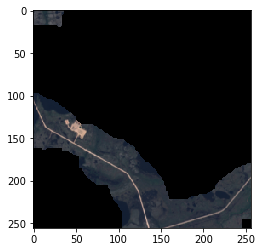

In [43]:
copy = image.copy()
copy[resized_b_m == 0] = 0
plt.imshow(copy)

In [44]:
mean_vector /= 255

In [45]:
masked_image = np.divide(masked_image, 255)
evkl = np.sqrt(np.sum((masked_image - mean_vector)**2, axis=1)) / np.sqrt(3)

In [46]:
print(masked_image.shape)
print(evkl.shape)

(15990, 3)
(15990,)


In [47]:
print(evkl.min(), evkl.max())

0.0009500417024189175 0.522859778957215


In [48]:
evkl = (evkl - evkl.min()) / (evkl.max() - evkl.min())

In [49]:
print(evkl.min(), evkl.max())

0.0 1.0


In [50]:
tr1 = 0.25
mask2d = resized_b_m.flatten()

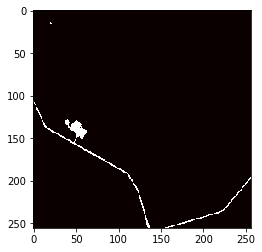

In [51]:
inner_mask = np.zeros_like(evkl)
inner_mask[evkl > tr1] = 1
mask2d[mask2d == 1] = inner_mask
plt.imshow(mask2d.reshape(256, 256), cmap='hot')

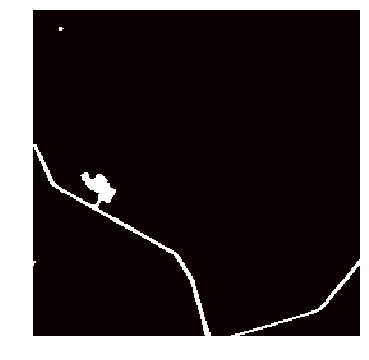

In [52]:
kernel = np.ones((3,3),np.uint8)
mask2d_changed = cv2.dilate(mask2d,kernel,iterations = 2)
kernel = np.ones((2,2),np.uint8)
mask2d_changed = cv2.erode(mask2d_changed,kernel,iterations = 2)
plt.figure(figsize = (6,6))
plt.imshow(mask2d_changed.reshape(256, 256), cmap='hot')
plt.axis('Off')
plt.show()

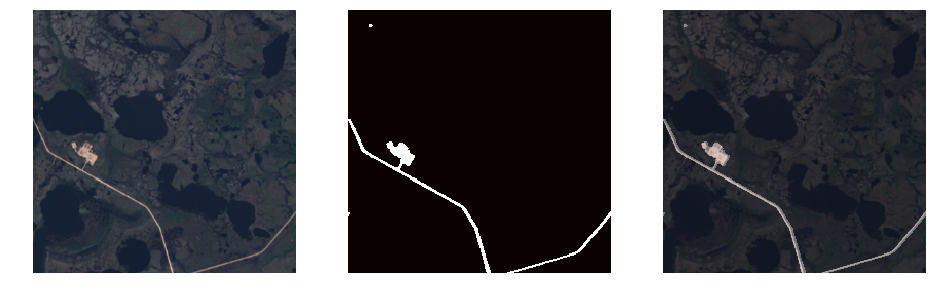

In [53]:
plt.figure(figsize = (16,10))
plt.subplot(1,3,1).imshow(image)
plt.subplot(1,3,1).axis('Off')
plt.subplot(1,3,2).imshow(mask2d_changed.reshape(256, 256), cmap='hot')
plt.subplot(1,3,2).axis('Off')
plt.subplot(1,3,3).imshow(image)
plt.subplot(1,3,3).imshow(mask2d_changed.reshape(256, 256),alpha = 0.3, cmap='hot')
plt.subplot(1,3,3).axis('Off')
plt.show()